In [12]:
# Holidays

# pip install pandas holidays python-dateutil
from datetime import date, timedelta
from dateutil.rrule import rrule, DAILY
import pandas as pd
import holidays

def calendar_with_holidays_karlsruhe_2014_2018():
    """
    Returns a pandas DataFrame listing every day from 2014-01-01 to 2018-12-31
    with weekday name, holiday flag, and holiday name for Karlsruhe, BW, Germany.
    (Holidays are state-level for Baden-Württemberg.)
    """
    start = date(2018, 1, 1)
    end   = date(2024, 12, 31)

    # Germany holidays, Baden-Württemberg (BW).
    # Works with recent versions of `holidays`:
    #   holidays.country_holidays('DE', subdiv='BW')
    # If you're on an older version, this also commonly works:
    #   holidays.Germany(subdiv='BW')  or holidays.Germany(prov='BW')
    de_bw = holidays.Germany(subdiv="BW", language="en_US")

    rows = []
    for dt in rrule(DAILY, dtstart=start, until=end):
        d = dt.date()
        name = de_bw.get(d)  # None if not a holiday
        rows.append({
            "date": d.isoformat(),
            "weekday": d.strftime("%A"),
            "is_holiday": name is not None,
            "holiday_name": name if name is not None else ""
        })

    df = pd.DataFrame(rows).astype({
        "date": "string",
        "weekday": "string",
        "is_holiday": "bool",
        "holiday_name": "string",
    })
    return df

# Example usage:
df = calendar_with_holidays_karlsruhe_2014_2018()
display(df.tail(2))
#df.to_csv("../dataset_clean/01exogenous_data/Holidays_Kalsruhe_bw_2018_2024.csv", index=False)


,date,weekday,is_holiday,holiday_name
2555,2024-12-30,Monday,False,
2556,2024-12-31,Tuesday,False,


Fetching SMARD day-ahead 15-min price (DE): 100%|██████████| 327/327 [00:26<00:00, 12.26it/s]


Saved CSV: D:\EnergyDataset\dataset_clean\01exogenous_data\electricity_prices_15min_de.csv


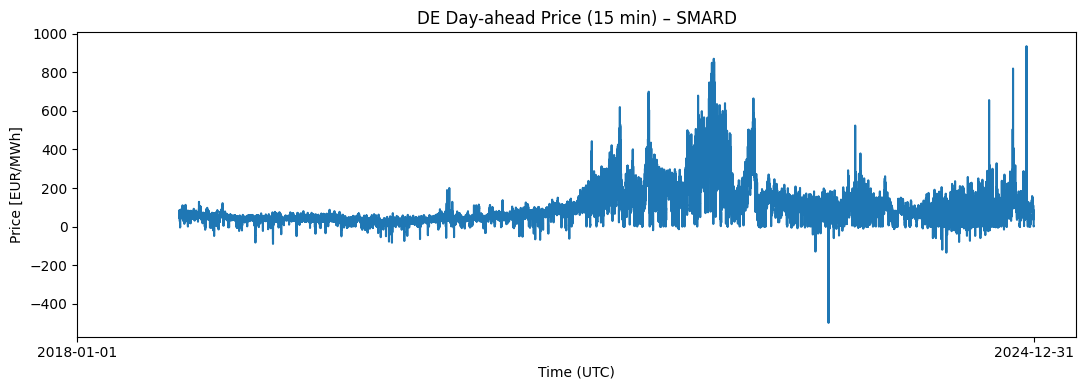

In [ ]:
"""Electricity Prices"""

# pip install requests pandas tqdm matplotlib
import pathlib
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

def build_de_prices_15min_smard(
    start="2018-01-01T00:00:00Z",
    end="2024-12-31T23:59:59Z",
    out_path="../dataset_clean/01exogenous_data/electricity_prices_15min_de.csv",
    save=True,
    plot=True,
):
    """
    Fetch DE day-ahead 15-min prices from SMARD chart API,
    align to a full 15-min grid with NaNs where data is unavailable,
    optionally save to CSV and plot (showing only first & last x-ticks).
    """
    START = pd.Timestamp(start, tz="UTC")
    END   = pd.Timestamp(end,   tz="UTC")

    # ---- SMARD chart API params ----
    FILTER = "4169"         # Day-ahead price
    REGION = "DE"           # Germany
    RES    = "quarterhour"  # 15-minute
    BASE   = "https://www.smard.de/app/chart_data"
    HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; smard-chart-downloader/1.0)"}

    def get_index_timestamps():
        url = f"{BASE}/{FILTER}/{REGION}/index_{RES}.json"
        r = requests.get(url, headers=HEADERS, timeout=60)
        r.raise_for_status()
        payload = r.json()
        ts = payload["timestamps"] if isinstance(payload, dict) and "timestamps" in payload else payload
        return sorted(int(x) for x in ts)

    def fetch_chunk(ts_ms: int):
        url = f"{BASE}/{FILTER}/{REGION}/{FILTER}_{REGION}_{RES}_{ts_ms}.json"
        r = requests.get(url, headers=HEADERS, timeout=60)
        r.raise_for_status()
        return r.json()

    def parse_series(obj: dict) -> pd.DataFrame:
        ser = None
        if isinstance(obj, dict):
            ser = obj.get("series") or obj.get("data")
        if not ser:
            return pd.DataFrame(columns=["utc_datetime", "price_eur_per_mwh"])
        rows = []
        for item in ser:
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                ms, val = item[0], item[1]
            elif isinstance(item, dict) and ("x" in item and "y" in item):
                ms, val = item["x"], item["y"]
            else:
                continue
            if val is None:
                continue
            rows.append((pd.to_datetime(int(ms), unit="ms", utc=True), float(val)))
        return pd.DataFrame(rows, columns=["utc_datetime", "price_eur_per_mwh"])

    # ---- Fetch & assemble ----
    end_ms = int(END.timestamp() * 1000)
    ts_list = [ts for ts in get_index_timestamps() if ts <= end_ms]

    frames = []
    for ts in tqdm(ts_list, desc="Fetching SMARD day-ahead 15-min price (DE)"):
        try:
            obj = fetch_chunk(ts)
            df = parse_series(obj)
        except Exception as e:
            print(f"[WARN] skipping chunk {ts}: {e}")
            continue
        if df.empty:
            continue
        df = df[(df["utc_datetime"] >= START) & (df["utc_datetime"] <= END)]
        if not df.empty:
            frames.append(df)

    # If nothing fetched, still produce empty frame on full grid with NaNs
    if frames:
        data = (pd.concat(frames, ignore_index=True)
                  .drop_duplicates("utc_datetime")
                  .sort_values("utc_datetime")
                  .reset_index(drop=True))
    else:
        data = pd.DataFrame(columns=["utc_datetime", "price_eur_per_mwh"])

    # ---- Full 15-min grid with NaNs where missing ----
    full_index = pd.date_range(START, END, freq="15min", tz="UTC")
    data = (data.set_index("utc_datetime")
                .reindex(full_index)  # NaNs for gaps / pre-availability
                .rename_axis("utc_datetime")
                .reset_index())

    # ---- Save ----
    out_path = pathlib.Path(out_path)
    if save:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        data.to_csv(out_path, index=False)
        print(f"Saved CSV: {out_path.resolve()}")

    # ---- Plot ----
    if plot:
        fig, ax = plt.subplots(figsize=(11, 4))
        ax.plot(data["utc_datetime"], data["price_eur_per_mwh"])
        # x-axis: only first & last date
        ax.set_xticks([data["utc_datetime"].iloc[0], data["utc_datetime"].iloc[-1]])
        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Price [EUR/MWh]")
        ax.set_title("DE Day-ahead Price (15 min) – SMARD")
        plt.tight_layout()
        plt.show()

    return data

# Example:
df = build_de_prices_15min_smard(save=True, plot=True)


[WARN] 1223 index: 404 Client Error: Not Found for url: https://www.smard.de/app/chart_data/1223/TransnetBW/index_quarterhour.json


[WARN] 1225 index: 404 Client Error: Not Found for url: https://www.smard.de/app/chart_data/1225/TransnetBW/index_quarterhour.json


Saved CSV: D:\EnergyDataset\dataset_clean\01exogenous_data\electricitymix_15min_transnetbw_2018_2024.csv


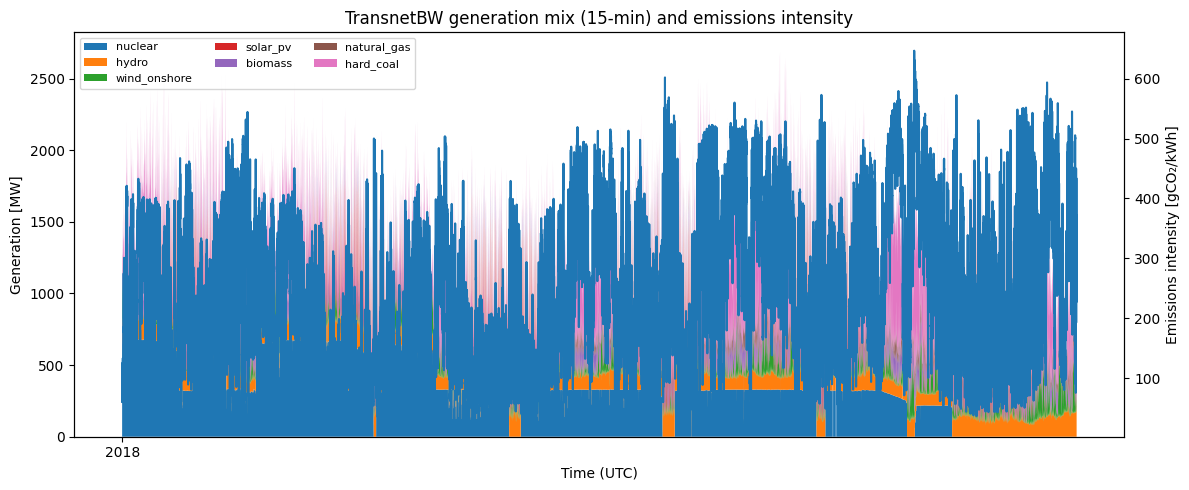

In [14]:
# pip install requests pandas tqdm matplotlib
import pathlib
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

def build_strommix_transnetbw_15min(
    start="2018-01-01T00:00:00Z",
    end="2024-12-31T23:59:59Z",
    out_path="../dataset_clean/01exogenous_data/electricitymix_15min_transnetbw_2018_2024.csv",
    save=True,
    plot=True,
):
    """
    Fetch quarter-hourly Strommix (generation mix) for TransnetBW (Baden-Württemberg),
    compute per-timestep emissions intensity (gCO2/kWh), align to full 15-min grid
    with NaNs where data is missing, and optionally save/plot.

    Emission intensity is based on *direct combustion* factors (approx.):
      - Lignite (Braunkohle):        1050 gCO2/kWh
      - Hard coal (Steinkohle):       811 gCO2/kWh
      - Gas (Erdgas):                 400 gCO2/kWh  (fleet-average, conservative)
      - Oil (part of "other conv."):  700 gCO2/kWh  (used for the "other conventional" bucket)
      - Nuclear, Hydro, Wind, Solar, Biomass: 0 gCO2/kWh (direct stack)
    Pumped-storage output is EXCLUDED from the intensity denominator & numerator.
    (It re-generates previously consumed grid electricity; attributing its emissions
     requires storage-roundtrip accounting beyond SMARD’s categories.)
    """

    START = pd.Timestamp(start, tz="UTC")
    END   = pd.Timestamp(end,   tz="UTC")

    # --- SMARD chart API config ---
    BASE    = "https://www.smard.de/app/chart_data"
    REGION  = "TransnetBW"       # Karlsruhe is inside TransnetBW (BW control area) otherwithe "De"
    RES     = "quarterhour"
    HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; smard-strommix-downloader/1.0)"}

    # Generation filter ids (SMARD):
    # See: https://www.smard.de/app/chart_data/{filter}/{region}/index_{resolution}.json
    # and https://github.com/bundesAPI/smard-api
    FILTERS = {
        # id: (english_name, include_in_emissions, emission_factor_g_per_kwh)
        "1223": ("lignite",                  True, 1119.0),  # Braunkohle -> 1119 g_per_kwh
        "1224": ("nuclear",                  True,    0.0),  # Kernenergie
        "1225": ("wind_offshore",            True,    0.0),
        "1226": ("hydro",                    True,    0.0),
        "1227": ("other_conventional",       True,  800.0),  # catch-all (oil etc.) -> approx
        "1228": ("other_renewables",         True,    0.0),
        "4066": ("biomass",                  True,    0.0),  # direct stack (biogenic CO2 not counted)
        "4067": ("wind_onshore",             True,    0.0),
        "4068": ("solar_pv",                 True,    0.0),
        "4069": ("hard_coal",                True,  860.0),  # Steinkohle -> 860 g_per_kwh
        "4070": ("pumped_storage_generation",False,   0.0),  # exclude from intensity math
        "4071": ("natural_gas",              True,  392.0), # -> 392 g_per_kwh
    }

    def idx_url(filter_id: str):
        return f"{BASE}/{filter_id}/{REGION}/index_{RES}.json"

    def chunk_url(filter_id: str, ts_ms: int):
        return f"{BASE}/{filter_id}/{REGION}/{filter_id}_{REGION}_{RES}_{ts_ms}.json"

    def get_timestamps(filter_id: str):
        r = requests.get(idx_url(filter_id), headers=HEADERS, timeout=60)
        r.raise_for_status()
        payload = r.json()
        ts = payload["timestamps"] if isinstance(payload, dict) and "timestamps" in payload else payload
        return sorted(int(x) for x in ts)

    def fetch_chunk(filter_id: str, ts_ms: int):
        r = requests.get(chunk_url(filter_id, ts_ms), headers=HEADERS, timeout=60)
        r.raise_for_status()
        return r.json()

    def parse_series(obj: dict) -> pd.DataFrame:
        ser = None
        if isinstance(obj, dict):
            ser = obj.get("series") or obj.get("data")
        if not ser:
            return pd.DataFrame(columns=["utc_datetime", "mw"])
        rows = []
        for item in ser:
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                ms, val = item[0], item[1]
            elif isinstance(item, dict) and ("x" in item and "y" in item):
                ms, val = item["x"], item["y"]
            else:
                continue
            if val is None:
                continue
            rows.append((pd.to_datetime(int(ms), unit="ms", utc=True), float(val)))
        return pd.DataFrame(rows, columns=["utc_datetime", "mw"])

    # ---------- pull & assemble per technology ----------
    frames = []
    for fid, (col_name, _, _) in FILTERS.items():
        try:
            # collect all chunks up to END
            ts_list = [ts for ts in get_timestamps(fid) if ts <= int(END.timestamp()*1000)]
        except Exception as e:
            print(f"[WARN] {fid} index: {e}")
            continue

        tech_frames = []
        for ts in tqdm(ts_list, desc=f"Fetching {col_name}", leave=False):
            try:
                obj = fetch_chunk(fid, ts)
                df = parse_series(obj)
            except Exception as e:
                print(f"[WARN] {fid} chunk {ts}: {e}")
                continue
            if df.empty:
                continue
            df = df[(df["utc_datetime"] >= START) & (df["utc_datetime"] <= END)]
            if not df.empty:
                tech_frames.append(df)

        if not tech_frames:
            continue

        tech = (pd.concat(tech_frames, ignore_index=True)
                  .drop_duplicates("utc_datetime")
                  .sort_values("utc_datetime")
                  .set_index("utc_datetime")
                  .rename(columns={"mw": col_name}))
        frames.append(tech)

    # Build full 15-min grid and join
    full_index = pd.date_range(START, END, freq="15min", tz="UTC")
    if frames:
        mix = pd.concat(frames, axis=1).reindex(full_index)  # MW per tech; NaNs where missing
    else:
        # No data fetched: return empty scaffold
        mix = pd.DataFrame(index=full_index)

    # ---------- emissions intensity ----------
    # Weighted by instantaneous generation (MW). Intensity = sum(gen_MW * factor)/sum(gen_MW_excl_pumped)
    include_cols = []
    factors = {}
    for fid, (name, include, ef) in FILTERS.items():
        if name in mix.columns:
            factors[name] = ef
            if include:
                include_cols.append(name)

    # sum generation for intensity denominator (exclude pumped-storage)
    denom = mix[include_cols].sum(axis=1, min_count=1)

    # numerator
    num = None
    for name in include_cols:
        ef = factors[name]
        term = mix[name] * ef
        num = term if num is None else (num + term)

    intensity = num / denom  # gCO2/kWh; NaN when denom is NaN/0
    mix["emission_intensity_g_per_kwh"] = intensity

    # ---------- friendly ordering ----------
    order = [
        "nuclear",
        "hydro",
        "wind_onshore",
        "wind_offshore",
        "solar_pv",
        "biomass",
        "other_renewables",
        "natural_gas",
        "hard_coal",
        "lignite",
        "other_conventional",
        "pumped_storage_generation",
        "emission_intensity_g_per_kwh",
    ]
    cols = [c for c in order if c in mix.columns] + [c for c in mix.columns if c not in order]
    data = mix[cols].reset_index().rename(columns={"index": "utc_datetime"})

    # ---------- save ----------
    out_path = pathlib.Path(out_path)
    if save:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        data.to_csv(out_path, index=False)
        print(f"Saved CSV: {out_path.resolve()}")

    # ---------- plot ----------
    if plot:
        fig, ax1 = plt.subplots(figsize=(12, 5))
        # stack area for major renewables + fossil (NaNs auto-gapped)
        stack_cols = [c for c in ["nuclear","hydro","wind_onshore","wind_offshore","solar_pv",
                                  "biomass","natural_gas","hard_coal","lignite"] if c in data.columns]
        ax1.stackplot(data["utc_datetime"], *(data[c] for c in stack_cols), labels=stack_cols)
        ax1.set_ylabel("Generation [MW]")
        # show only first & last date
        ax1.set_xticks([data["utc_datetime"].iloc[0], data["utc_datetime"].iloc[-1]])
        ax1.set_xlabel("Time (UTC)")

        # intensity on right axis
        if "emission_intensity_g_per_kwh" in data.columns:
            ax2 = ax1.twinx()
            ax2.plot(data["utc_datetime"], data["emission_intensity_g_per_kwh"])
            ax2.set_ylabel("Emissions intensity [gCO₂/kWh]")

        ax1.set_title("TransnetBW generation mix (15-min) and emissions intensity")
        # compact legend (first axis only)
        handles, labels = ax1.get_legend_handles_labels()
        if labels:
            ax1.legend(handles, labels, loc="upper left", ncol=3, fontsize=8)
        plt.tight_layout()
        plt.show()

    return data

# Example:
df = build_strommix_transnetbw_15min(save=True, plot=True)


No data available for given constraints
Traceback (most recent call last):
  File "d:\EnergyDataset\.venv\Lib\site-packages\wetterdienst\model\values.py", line 414, in all
    df = pl.concat(data)
         ^^^^^^^^^^^^^^^
  File "d:\EnergyDataset\.venv\Lib\site-packages\polars\functions\eager.py", line 173, in concat
    raise ValueError(msg)
ValueError: cannot concat empty list


Saved CSV: D:\EnergyDataset\dataset_clean\01exogenous_data\weather_data_karlsruhe_hourly_2018_2024.csv

Data sources used per parameter:
 - temperature_air_mean_2m_°C: DWD summarize() at Karlsruhe (stitched nearby stations automatically)
 - temperature_dew_point_mean_2m_°C: Nearest good station for temperature_dew_point_mean_2m: Waghäusel-Kirrlach (ID 05275, dist 28.1542 km, height 105.0 m)
 - humidity_%: DWD summarize() at Karlsruhe (stitched nearby stations automatically)
 - wind_speed_m/s: DWD summarize() at Karlsruhe (stitched nearby stations automatically)
 - wind_direction_°: Nearest good station for wind_direction: Rheinstetten (ID 04177, dist 6.5868 km, height 116.0 m)
 - wind_gust_max_m/s: Nearest good station for wind_gust_max: Rheinstetten (ID 04177, dist 6.5868 km, height 116.0 m)
 - pressure_air_site_hPa: Nearest good station for pressure_air_site: Waibstadt (ID 13674, dist 48.4988 km, height 237.0 m)
 - pressure_air_sea_level_hPa: Nearest good station for pressure_air_sea

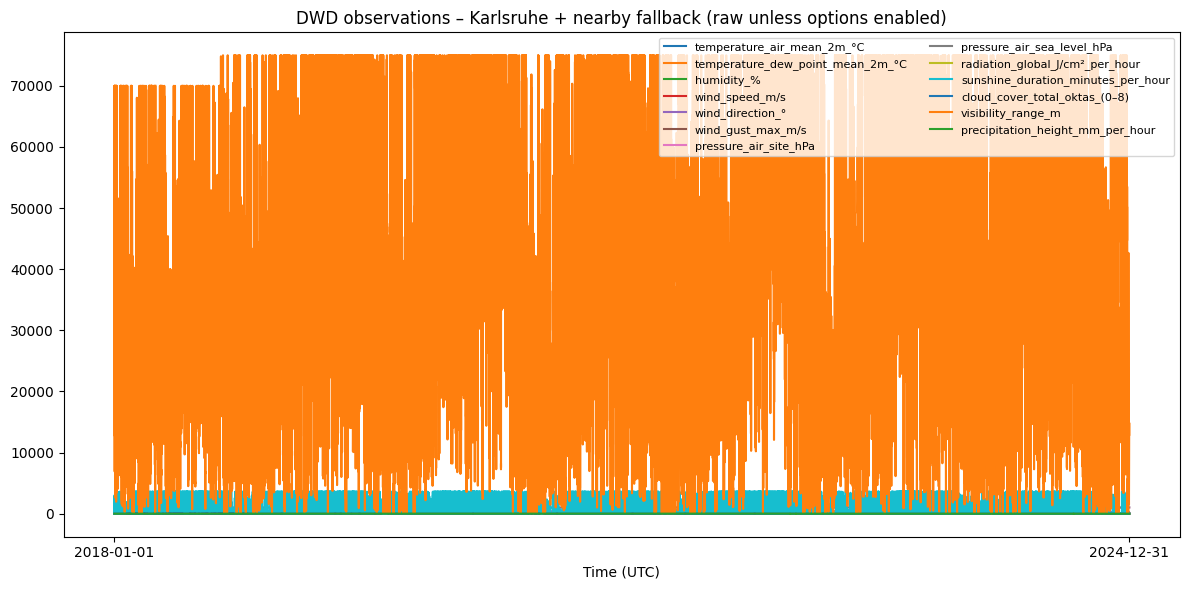

In [ ]:
"""Weather Data"""
# pip install wetterdienst pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from wetterdienst.settings import Settings
SETTINGS = Settings(cache_disable=True)  # or: Settings(cache_dir="./.wd_cache")


def fetch_dwd_weather_karlsruhe_with_nearby_fallback(
    start="2018-01-01",
    end="2024-12-31 23:59:59",
    lat=49.0069, lon=8.4037,  # Karlsruhe center
    out_csv="../dataset_clean/01exogenous_data/weather_data_karlsruhe_hourly_2018_2024.csv",
    out_meta="../dataset_clean/01exogenous_data/weather_data_stations_used.csv",
    save=True,
    plot=True,

    # ---- processing controls (defaults = RAW, no artificial values) ----
    enforce_full_hourly=False,   # if True: reindex to full hourly grid (may create NaNs)

    # ---- fallback search controls ----
    coverage_threshold=0.05,     # if Karlsruhe coverage < 5%, search nearby stations
    search_distance_km=80,       # search radius for nearby stations
    consider_top_n_stations=8    # check up to N nearest stations
):
    """
    Download DWD weather (hourly) for Karlsruhe using wetterdienst.
    DEFAULT: no filling, no resampling. Columns include units in names.
    NEW: If a parameter is missing/scarce at Karlsruhe, search nearby stations and
         use the best-coverage station (tie -> closer distance).

    Notes:
      - Each parameter may come from a different nearby station.
      - We still keep original timestamps (no artificial values unless resample_to_15min=True).
      - 'coverage_threshold' is fraction of possible hourly points in [start, end].
    """
    START = pd.Timestamp(start, tz="UTC")
    END   = pd.Timestamp(end,   tz="UTC")

    # Parameters: (resolution, dataset, parameter) — all hourly
    params = [
        # Temperature & humidity
        ("hourly", "temperature_air", "temperature_air_mean_2m"),
        ("hourly", "dew_point",       "temperature_dew_point_mean_2m"),
        ("hourly", "moisture",        "humidity"),

        # Wind
        ("hourly", "wind",            "wind_speed"),
        ("hourly", "wind",            "wind_direction"),
        ("hourly", "wind_extreme",    "wind_gust_max"),

        # Pressure
        ("hourly", "pressure",        "pressure_air_site"),
        ("hourly", "pressure",        "pressure_air_sea_level"),

        # Radiation & sun
        ("hourly", "solar",           "radiation_global"),
        ("hourly", "sun",             "sunshine_duration"),

        # Clouds & visibility
        ("hourly", "cloudiness",      "cloud_cover_total"),
        ("hourly", "visibility",      "visibility_range"),

        # Precipitation
        ("hourly", "precipitation",   "precipitation_height"),

        # Weather code (readable)
        ("hourly", "weather_phenomena","weather_text"),
    ]

    # Units to append in column headers
    units = {
        "temperature_air_mean_2m":        "°C",
        "temperature_dew_point_mean_2m":  "°C",
        "humidity":                       "%",
        "wind_speed":                     "m/s",
        "wind_direction":                 "°",
        "wind_gust_max":                  "m/s",
        "pressure_air_site":              "hPa",
        "pressure_air_sea_level":         "hPa",
        "radiation_global":               "J/cm²_per_hour",  # DWD solar hourly is J per cm²
        "sunshine_duration":              "minutes_per_hour",
        "cloud_cover_total":              "oktas_(0–8)",
        "visibility_range":               "m",
        "precipitation_height":           "mm_per_hour",
        "weather_text":                   "categorical",
    }

    def _to_pandas(df_like):
        if hasattr(df_like, "to_pandas"):
            try:
                return df_like.to_pandas()
            except Exception:
                pass
        return pd.DataFrame(df_like)

    # Helper: fetch best series for ONE parameter with fallback
    def fetch_param_with_fallback(resolution, dataset, parameter):
        colname = parameter
        # 1) Try summarize() at Karlsruhe coords (stitching across time automatically)
        req = DwdObservationRequest(parameters=[(resolution, dataset, parameter)],
                                    start_date=START, end_date=END, settings=SETTINGS)
        vals = req.summarize(latlon=(lat, lon))
        df_long = _to_pandas(vals.df)

        # compute coverage at Karlsruhe summary (could be 0)
        if not df_long.empty:
            series_karlsruhe = (
                df_long.rename(columns={"date":"utc_datetime"})
                       .loc[df_long["parameter"] == parameter, ["utc_datetime","value"]]
                       .dropna()
            )
        else:
            series_karlsruhe = pd.DataFrame(columns=["utc_datetime","value"])

        # possible hourly timestamps count (for coverage denominator)
        possible_hours = int(((END - START).total_seconds() // 3600) + 1)
        coverage_karlsruhe = (len(series_karlsruhe) / possible_hours) if possible_hours > 0 else 0.0

        if coverage_karlsruhe >= coverage_threshold:
            # good enough: use summarize result (already stitched)
            meta_df = _to_pandas(vals.stations.df)
            source_info = "DWD summarize() at Karlsruhe (stitched nearby stations automatically)"
            return series_karlsruhe, source_info, meta_df

        # 2) Not enough: search nearby stations by distance and pick best coverage
        stations = req.filter_by_distance(latlon=(lat, lon), distance=search_distance_km)
        stations_df = _to_pandas(stations.df).sort_values("distance").reset_index(drop=True)
        if stations_df.empty:
            return series_karlsruhe, "No nearby stations found", pd.DataFrame()

        # consider top N nearest
        candidate_ids = stations_df["station_id"].head(consider_top_n_stations).tolist()
        # Pull raw values for these stations
        # Pull raw values for these stations (guard against empty constraints)
        try:
            vals2 = stations.values.all()
            df_all = _to_pandas(vals2.df)
        except Exception as e:
            return series_karlsruhe, f"Nearby stations failed: {e}", stations_df

        if df_all.empty:
            return series_karlsruhe, "Nearby stations returned no values", stations_df

        # Keep desired param only
        df_param = df_all[df_all["parameter"] == parameter].copy()
        if df_param.empty:
            return series_karlsruhe, "Nearby stations lack parameter values", stations_df

        # Compute coverage per candidate station
        best_row = None
        best_cov = -1.0
        for sid in candidate_ids:
            sub = df_param[df_param["station_id"] == sid]
            cov = sub["value"].notna().sum() / possible_hours
            if cov > best_cov:
                best_cov = cov
                best_row = sid

        if best_row is None or best_cov <= 0:
            return series_karlsruhe, "No coverage from nearby stations", stations_df

        # Extract that station's time series
        chosen = df_param[df_param["station_id"] == best_row][["date","value"]].rename(columns={"date":"utc_datetime"})
        # enrich with station meta for printing
        meta_row = stations_df[stations_df["station_id"] == best_row].head(1)
        if not meta_row.empty:
            source_info = (f"Nearest good station for {parameter}: "
                           f"{meta_row.iloc[0].get('name','?')} "
                           f"(ID {best_row}, dist {meta_row.iloc[0].get('distance','?')} km, "
                           f"height {meta_row.iloc[0].get('height','?')} m)")
            meta_df = meta_row
        else:
            source_info = f"Station {best_row} (details not found)"
            meta_df = pd.DataFrame()

        return chosen, source_info, meta_df

    # For each parameter, fetch with fallback and assemble columns
    collected = []
    source_notes = []   # text per column
    meta_records = []   # small meta rows per column

    for (res, ds, par) in params:
        series, note, meta = fetch_param_with_fallback(res, ds, par)
        if not series.empty:
            # ensure datetime index & sort
            s = (series.dropna()
                        .drop_duplicates(subset=["utc_datetime"])
                        .sort_values("utc_datetime")
                        .set_index(pd.to_datetime(series["utc_datetime"], utc=True)))
            # name with units
            col = f"{par}_{units.get(par, '')}".rstrip("_")
            s = s[["value"]].rename(columns={"value": col})
            collected.append(s)
            source_notes.append(f"{col}: {note}")
            if not meta.empty:
                m = meta.copy()
                m["parameter"] = par
                meta_records.append(m)

    if not collected:
        raise RuntimeError("No data could be collected for any parameter (check time span / connectivity).")

    # Outer-join on native timestamps (no filling)
    data = pd.concat(collected, axis=1).sort_index()

    # OPTIONAL: enforce full hourly grid (no value fills)
    if enforce_full_hourly:
        hourly_index = pd.date_range(START, END, freq="h", tz="UTC")
        data = data.reindex(hourly_index)

    # OPTIONAL: resample to 15 min (creates artificial values if fill_method is used)
    data_out = data

    # Save
    if save:
        Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        (data_out.rename_axis("utc_datetime")
                 .reset_index()
                 .to_csv(out_csv, index=False))
        print(f"Saved CSV: {Path(out_csv).resolve()}")

    # Print per-parameter source notes
    print("\nData sources used per parameter:")
    for line in source_notes:
        print(" -", line)

    # Print a compact table of chosen stations (if any)
    if meta_records:
        meta_table = pd.concat(meta_records, ignore_index=True)
        cols_pref = [c for c in ["parameter","station_id","name","state","distance","height","latitude","longitude","from_date","to_date"] if c in meta_table.columns]
        print("\nChosen station(s) summary:")
        meta_view = meta_table[cols_pref]
        print(meta_view.to_string(index=False))

        # Save metadata next to main CSV unless out_meta is provided
        if save and not meta_view.empty:
            meta_out = Path(out_meta) if out_meta else Path(out_csv).with_name(
                Path(out_csv).stem + "_stations.csv"
            )
            meta_view.to_csv(meta_out, index=False)
            print(f"Saved station meta CSV: {meta_out.resolve()}")


    # Plot ALL series (first & last x-ticks only)
    if plot and not data_out.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        for col in data_out.columns:
            ax.plot(data_out.index, data_out[col], label=col)
        ax.set_xticks([data_out.index[0], data_out.index[-1]])
        ax.set_xlabel("Time (UTC)")
        ax.set_title("DWD observations – Karlsruhe + nearby fallback (raw unless options enabled)")
        ax.legend(loc="upper right", fontsize=8, ncol=2)
        plt.tight_layout()
        plt.show()

    return data_out

# Example (RAW, no artificial values, with nearby fallback):
df_weather = fetch_dwd_weather_karlsruhe_with_nearby_fallback()
